In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(rc={'figure.figsize':(12,9)})

In [2]:
kc = pd.read_csv('./source/kc_house_data.csv', parse_dates=[1,14])

In [3]:
properties_data_altered = {}
for i in range(0,len(kc['id'])-1):
        if kc['sqft_basement'][i] == '?':
            kc['sqft_basement'][i] = 0
        properties_data_altered[kc['id'][i]] = 'sqft_basement'

# 33 bedrooms house? It is a typo (the 11 bedrooms one checks out though)
properties_data_altered[kc[kc['bedrooms']==33].iloc[0]['id']] = '33_bedrooms'
kc['bedrooms'] = kc['bedrooms'].replace(33,3)

# view, 63 empties changed to zeros
for i in kc[kc['view'].isnull()]['id']:
    properties_data_altered[i] = 'views'
kc['view'] = kc['view'].fillna(0)

# yr_renovated, 16900 zeros changed to NaN
for i in kc[kc['yr_renovated']=='0.0']['id']:
    properties_data_altered[i] = 'yr_renovated'
kc['yr_renovated'] = kc['yr_renovated'].replace('0.0', np.nan)

# sorting out data types:
kc['id'] = kc['id'].astype(str)
# kc['bathrooms'] = kc['bathrooms'].astype(str)
# kc['bedrooms'] = kc['bedrooms'].astype(str)
# kc['condition'] = kc['condition'].astype(str)
# kc['floors'] = kc['floors'].astype(str)
# kc['grade'] = kc['grade'].astype(str)
kc['sqft_basement'] = kc['sqft_basement'].astype(float)
# kc['view'] = kc['view'].astype(str)
# kc['waterfront'] = kc['waterfront'].astype(str)
kc['yr_renovated'] = pd.to_datetime(kc['yr_renovated'])
kc['zipcode'] = kc['zipcode'].astype(str)

# split dataframes: properties sold more than once in the timeframe vs all properties without duplicates
kc_duplicated = kc[kc.duplicated(['id'],keep=False)]
kc = kc.sort_values('date').drop_duplicates('id',keep='last')


kc.info()

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 7316 to 16580
Data columns (total 21 columns):
id               21420 non-null object
date             21420 non-null datetime64[ns]
price            21420 non-null float64
bedrooms         21420 non-null int64
bathrooms        21420 non-null float64
sqft_living      21420 non-null int64
sqft_lot         21420 non-null int64
floors           21420 non-null float64
waterfront       19067 non-null float64
view             21420 non-null float64
condition        21420 non-null int64
grade            21420 non-null int64
sqft_above       21420 non-null int64
sqft_basement    21420 non-null float64
yr_built         21420 non-null datetime64[ns]
yr_renovated     17607 non-null datetime64[ns]
zipcode          21420 non-null object
lat              21420 non-null float64
long             21420 non-null float64
sqft_living15    21420 non-null int64
sqft_lot15       21420 non-null int64
dtypes: datetime64[ns](3), float64(8), int64(

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [4]:
kc.zipcode

7316     98006
20586    98065
1040     98052
20543    98106
9587     98117
         ...  
19381    98116
12623    98023
5632     98007
13040    98115
16580    98115
Name: zipcode, Length: 21420, dtype: object

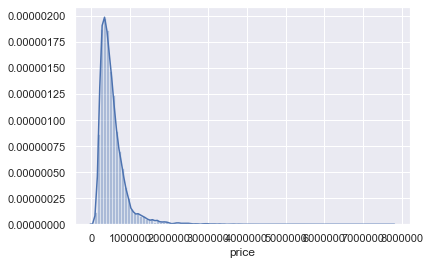

<Figure size 864x648 with 0 Axes>

In [5]:

sns.distplot(kc['price'], bins=100, hist_kws={'alpha':0.4})
fig = plt.figure(figsize=(12,9))


In [6]:
kc['price'].skew()

4.035378874466088

In [7]:
kc['price'].kurt()

34.680504355450644

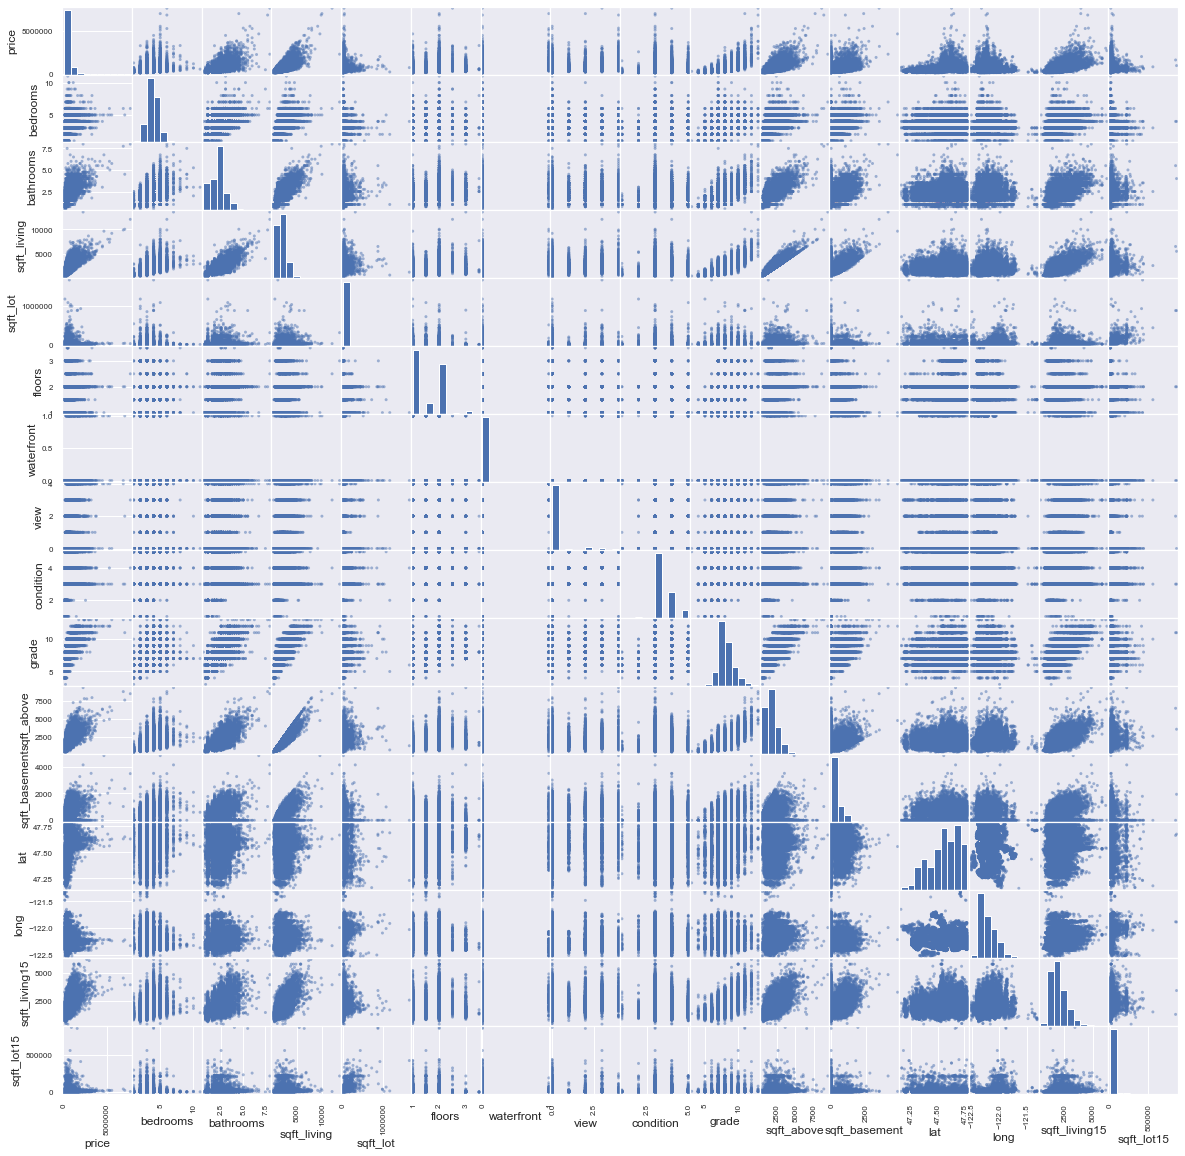

In [8]:
pd.plotting.scatter_matrix(kc,figsize  = [20, 20]);
plt.show()

In [9]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


In [10]:
kc.zipcode.value_counts()

98103    600
98038    586
98115    576
98052    571
98117    548
        ... 
98102    104
98010     99
98024     79
98148     56
98039     49
Name: zipcode, Length: 70, dtype: int64

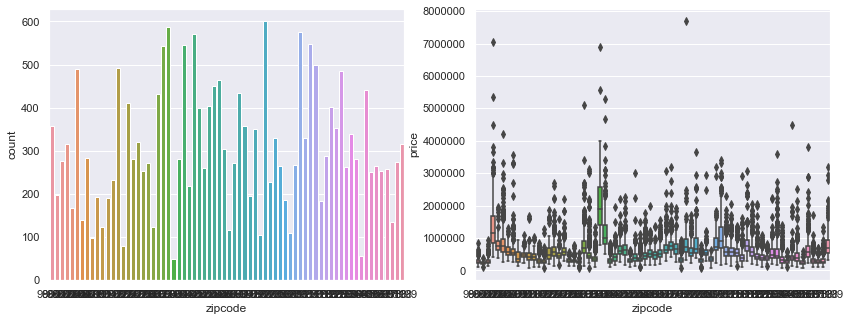

In [11]:
zipcode = kc['zipcode'].value_counts()



fig, ax = plt.subplots(ncols=2, figsize=(14,5))
sns.countplot(x='zipcode', data=kc, ax=ax[0])
sns.boxplot(x='zipcode', y= 'price',
            data=kc, ax=ax[1])
plt.show()

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x576 with 0 Axes>

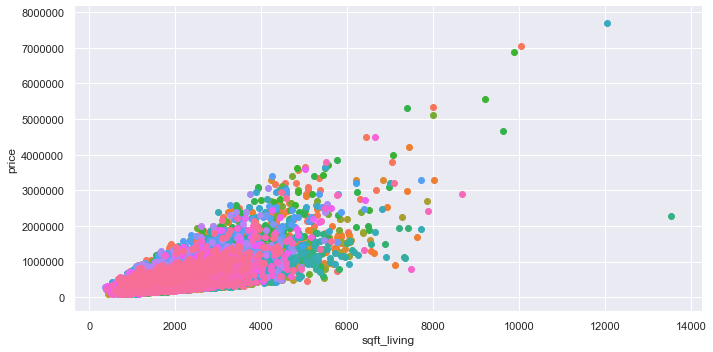

In [12]:
plt.figure(figsize = (12,8))
g = sns.FacetGrid(data=kc, hue='zipcode',size= 5, aspect=2)
g.map(plt.scatter, "sqft_living", "price")

plt.show()

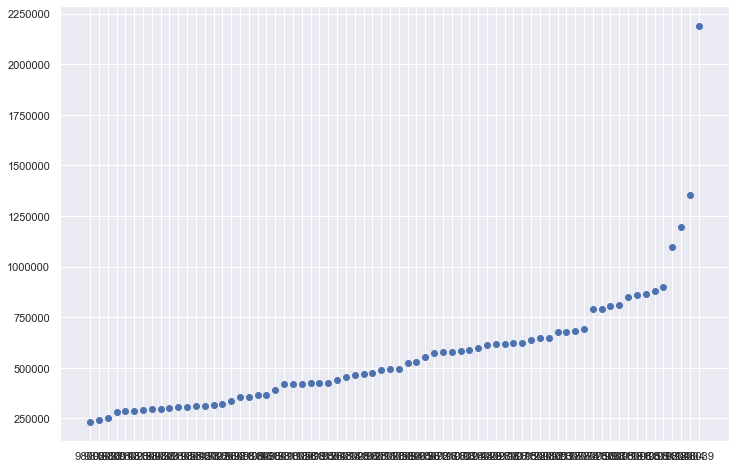

In [13]:
kc_zip = kc.groupby('zipcode')['price'].mean().reset_index()

kc_zip = kc_zip.sort_values(by=['price'])

plt.figure(figsize = (12,8))
plt.scatter(x=kc_zip['zipcode'], y=kc_zip['price'])


In [14]:
import folium
import geopandas as gpd

In [15]:
kc_zip_mean= kc.groupby('zipcode').aggregate(np.mean)
kc_zip_mean.head()
kc_zip_mean.drop(['lat', 'long'], axis=1, inplace=True)

kc_zip_mean.reset_index(inplace = True)
kc_zip_mean.head()



,zipcode,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15
0,98001,2.822688e+05,3.402235,2.012570,1908.256983,14966.393855,1.432961,0.000000,0.094972,3.329609,7.296089,1726.720670,181.536313,1832.279330,11200.337989
1,98002,2.346067e+05,3.314721,1.837563,1627.416244,7509.248731,1.332487,0.000000,0.010152,3.751269,6.695431,1521.142132,106.274112,1478.461929,7587.690355
2,98003,2.958119e+05,3.358696,2.053442,1931.438406,10625.137681,1.309783,0.000000,0.217391,3.373188,7.550725,1663.384058,261.750000,1880.416667,9771.572464
3,98004,1.355972e+06,3.853968,2.530159,2910.730159,13084.374603,1.431746,0.003559,0.307937,3.495238,8.688889,2418.444444,492.285714,2672.634921,12798.577778
4,98005,8.102897e+05,3.851190,2.424107,2656.803571,19928.785714,1.279762,0.000000,0.095238,3.696429,8.488095,2160.196429,485.952381,2567.863095,18367.773810


In [16]:

map_kc = gpd.read_file('source/Zip_Codes/Zip_Codes.shp')

map_kc.head()


,OBJECTID,ZIP,ZIPCODE,COUNTY,SHAPE_Leng,SHAPE_Area,geometry
0,1,98031,98031,033,117508.211718,2.280129e+08,"POLYGON ((-122.21842 47.43750, -122.21935 47.4..."
1,2,98032,98032,033,166737.664791,4.826754e+08,"MULTIPOLYGON (((-122.24187 47.44122, -122.2411..."
2,3,98033,98033,033,101363.840369,2.566747e+08,"POLYGON ((-122.20571 47.65170, -122.20511 47.6..."
3,4,98034,98034,033,98550.452509,2.725072e+08,"POLYGON ((-122.17551 47.73706, -122.17554 47.7..."
4,5,98030,98030,033,94351.264837,2.000954e+08,"POLYGON ((-122.16746 47.38549, -122.16746 47.3..."


In [17]:

map_kc['zipcode'] = map_kc['ZIPCODE']
map_kc.drop(['ZIP', 'ZIPCODE', 'OBJECTID'], axis=1, inplace=True)
map_kc.head()

,COUNTY,SHAPE_Leng,SHAPE_Area,geometry,zipcode
0,033,117508.211718,2.280129e+08,"POLYGON ((-122.21842 47.43750, -122.21935 47.4...",98031
1,033,166737.664791,4.826754e+08,"MULTIPOLYGON (((-122.24187 47.44122, -122.2411...",98032
2,033,101363.840369,2.566747e+08,"POLYGON ((-122.20571 47.65170, -122.20511 47.6...",98033
3,033,98550.452509,2.725072e+08,"POLYGON ((-122.17551 47.73706, -122.17554 47.7...",98034
4,033,94351.264837,2.000954e+08,"POLYGON ((-122.16746 47.38549, -122.16746 47.3...",98030


In [18]:
merged = pd.merge(map_kc, kc_zip_mean, on='zipcode')

merged.head()

,COUNTY,SHAPE_Leng,SHAPE_Area,geometry,zipcode,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15
0,033,117508.211718,2.280129e+08,"POLYGON ((-122.21842 47.43750, -122.21935 47.4...",98031,300970.405904,3.498155,2.154982,1932.273063,12138.682657,1.446494,0.000000,0.007380,3.498155,7.380074,1708.804428,205.276753,1911.317343,8488.538745
1,033,166737.664791,4.826754e+08,"MULTIPOLYGON (((-122.24187 47.44122, -122.2411...",98032,253317.317073,3.406504,1.713415,1745.577236,10395.894309,1.223577,0.000000,0.081301,3.642276,7.146341,1436.910569,308.666667,1670.317073,9291.959350
2,033,101363.840369,2.566747e+08,"POLYGON ((-122.20571 47.65170, -122.20511 47.6...",98033,804063.883991,3.559165,2.333527,2379.371230,10508.206497,1.495360,0.008000,0.299304,3.487239,8.074246,2058.150812,316.371230,2207.243619,9929.505800
3,033,98550.452509,2.725072e+08,"POLYGON ((-122.17551 47.73706, -122.17554 47.7...",98034,522298.909761,3.462247,2.123389,1977.657459,9770.451197,1.317680,0.010373,0.202578,3.381215,7.506446,1662.025783,309.333333,1913.158379,8491.079190
4,033,94351.264837,2.000954e+08,"POLYGON ((-122.16746 47.38549, -122.16746 47.3...",98030,297939.221344,3.505929,2.169960,1970.118577,11802.505929,1.505929,0.000000,0.023715,3.292490,7.422925,1809.802372,158.221344,1924.743083,8576.122530


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:459: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  FutureWarning,


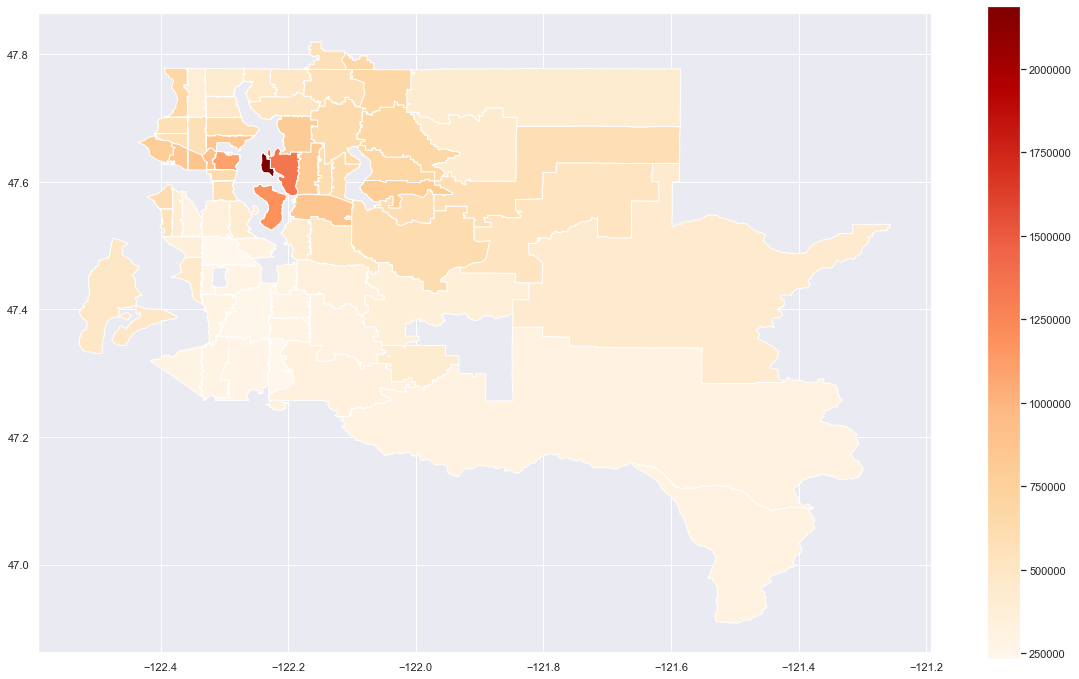

In [19]:
gdf=gpd.GeoDataFrame(merged, geometry=merged.geometry)

gdf.plot(column='price', k=5, colormap='OrRd', legend=True, figsize=(20,12))


In [20]:
import fiona
import pysal as ps

from IPython.display import IFrame
gdf_test = gpd.read_file('source/Zip_Codes/Zip_Codes.shp')


gdf_test.head()

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/numba/decorators.py:29: NumbaDeprecationWarning: autojit is deprecated, use jit instead, which provides the same functionality. For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-numba-autojit
  warnings.warn(NumbaDeprecationWarning(msg))


,OBJECTID,ZIP,ZIPCODE,COUNTY,SHAPE_Leng,SHAPE_Area,geometry
0,1,98031,98031,033,117508.211718,2.280129e+08,"POLYGON ((-122.21842 47.43750, -122.21935 47.4..."
1,2,98032,98032,033,166737.664791,4.826754e+08,"MULTIPOLYGON (((-122.24187 47.44122, -122.2411..."
2,3,98033,98033,033,101363.840369,2.566747e+08,"POLYGON ((-122.20571 47.65170, -122.20511 47.6..."
3,4,98034,98034,033,98550.452509,2.725072e+08,"POLYGON ((-122.17551 47.73706, -122.17554 47.7..."
4,5,98030,98030,033,94351.264837,2.000954e+08,"POLYGON ((-122.16746 47.38549, -122.16746 47.3..."


In [21]:
%store -r hot_zip_codes
hot_zip_codes.reset_index(inplace=True)
hot_zip_codes['zipcode']=hot_zip_codes['zipcode'].astype(str)


In [22]:
hot_zip_codes.drop(['lat', 'long'], axis=1, inplace=True)
hot_zip_codes

,zipcode,rate_of_price_increase
0,98034,2096.773109
1,98155,1726.637060
2,98126,1669.871795
3,98117,1568.664443
4,98011,1544.117647
5,98177,1470.588235
6,98148,1397.119342
7,98007,1344.377059
8,98199,1327.419492
9,98118,1265.915608


In [23]:
appended_data = []

for zipcode in list(kc['zipcode'].unique()):
    if zipcode not in list(hot_zip_codes['zipcode']):
        appended_data.append({'zipcode':zipcode, 'rate_of_price_increase':0})
        
appended_df = pd.DataFrame(data=appended_data)

merged_df = pd.concat([hot_zip_codes, appended_df], axis=0)

merged_df['zipcode'].nunique()

70

In [24]:
merged_2 = pd.merge(merged, merged_df, on='zipcode')

merged_2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 20 columns):
COUNTY                    74 non-null object
SHAPE_Leng                74 non-null float64
SHAPE_Area                74 non-null float64
geometry                  74 non-null geometry
zipcode                   74 non-null object
price                     74 non-null float64
bedrooms                  74 non-null float64
bathrooms                 74 non-null float64
sqft_living               74 non-null float64
sqft_lot                  74 non-null float64
floors                    74 non-null float64
waterfront                74 non-null float64
view                      74 non-null float64
condition                 74 non-null float64
grade                     74 non-null float64
sqft_above                74 non-null float64
sqft_basement             74 non-null float64
sqft_living15             74 non-null float64
sqft_lot15                74 non-null float64
rate_of_price_in

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:459: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  FutureWarning,


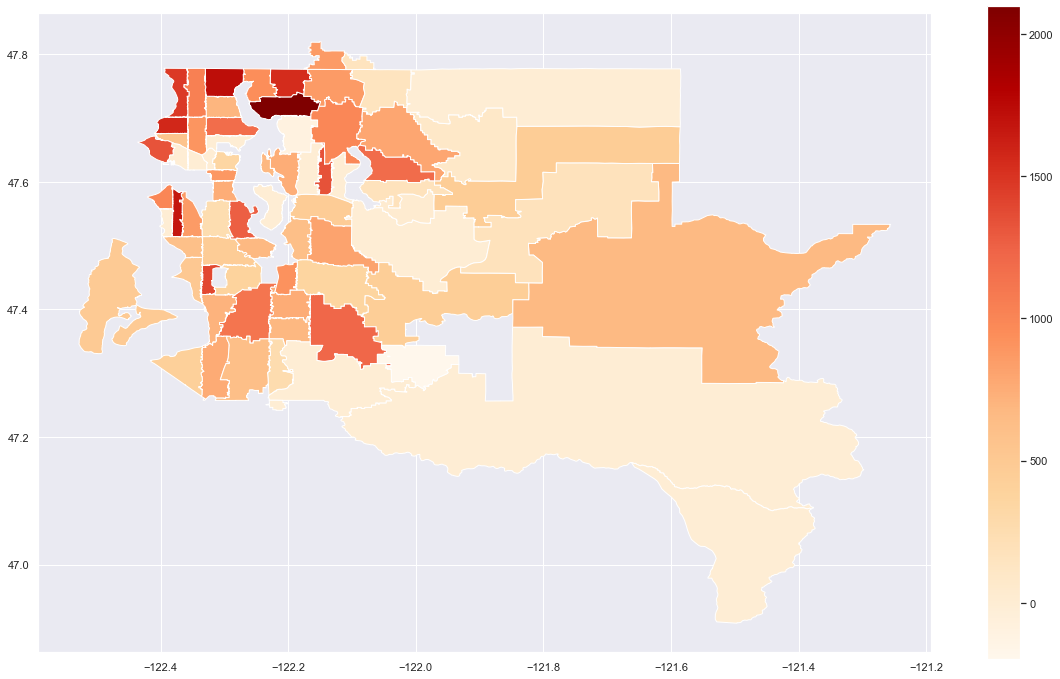

In [25]:
gdf=gpd.GeoDataFrame(merged_2, geometry=merged_2.geometry)

gdf.plot(column='rate_of_price_increase', k=5, colormap='OrRd', legend=True, figsize=(20,12))


In [26]:
merged_2

,COUNTY,SHAPE_Leng,SHAPE_Area,geometry,zipcode,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,rate_of_price_increase
0,033,117508.211718,2.280129e+08,"POLYGON ((-122.21842 47.43750, -122.21935 47.4...",98031,300970.405904,3.498155,2.154982,1932.273063,12138.682657,1.446494,0.000000,0.007380,3.498155,7.380074,1708.804428,205.276753,1911.317343,8488.538745,756.605527
1,033,166737.664791,4.826754e+08,"MULTIPOLYGON (((-122.24187 47.44122, -122.2411...",98032,253317.317073,3.406504,1.713415,1745.577236,10395.894309,1.223577,0.000000,0.081301,3.642276,7.146341,1436.910569,308.666667,1670.317073,9291.959350,1127.812321
2,033,101363.840369,2.566747e+08,"POLYGON ((-122.20571 47.65170, -122.20511 47.6...",98033,804063.883991,3.559165,2.333527,2379.371230,10508.206497,1.495360,0.008000,0.299304,3.487239,8.074246,2058.150812,316.371230,2207.243619,9929.505800,-94.936709
3,033,98550.452509,2.725072e+08,"POLYGON ((-122.17551 47.73706, -122.17554 47.7...",98034,522298.909761,3.462247,2.123389,1977.657459,9770.451197,1.317680,0.010373,0.202578,3.381215,7.506446,1662.025783,309.333333,1913.158379,8491.079190,2096.773109
4,033,94351.264837,2.000954e+08,"POLYGON ((-122.16746 47.38549, -122.16746 47.3...",98030,297939.221344,3.505929,2.169960,1970.118577,11802.505929,1.505929,0.000000,0.023715,3.292490,7.422925,1809.802372,158.221344,1924.743083,8576.122530,690.409695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,033,95211.465988,1.596729e+08,"POLYGON ((-122.35904 47.77776, -122.35904 47.7...",98177,677625.767717,3.397638,2.099409,2325.511811,11921.086614,1.277559,0.004274,0.814961,3.496063,7.976378,1838.944882,473.377953,2186.220472,11704.362205,1470.588235
70,033,66906.676245,1.353505e+08,"POLYGON ((-122.21902 47.50057, -122.21902 47.5...",98178,312850.937984,3.306202,1.738372,1736.744186,8308.457364,1.186047,0.039301,0.542636,3.325581,6.829457,1329.728682,399.612403,1650.503876,8132.344961,679.096335
71,033,124157.387829,2.108446e+08,"POLYGON ((-122.31456 47.42438, -122.31454 47.4...",98198,305287.589091,3.178182,1.792727,1749.530909,10553.425455,1.225455,0.037975,0.603636,3.450909,7.109091,1477.785455,264.436364,1715.927273,9502.130909,715.322553
72,033,56826.422800,1.145346e+08,"MULTIPOLYGON (((-122.40912 47.67160, -122.4089...",98199,792939.325949,3.208861,2.166930,2162.246835,5439.721519,1.466772,0.003636,0.553797,3.503165,8.009494,1591.487342,565.601266,1992.341772,5282.101266,1327.419492


In [27]:
merged_2

,COUNTY,SHAPE_Leng,SHAPE_Area,geometry,zipcode,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,rate_of_price_increase
0,033,117508.211718,2.280129e+08,"POLYGON ((-122.21842 47.43750, -122.21935 47.4...",98031,300970.405904,3.498155,2.154982,1932.273063,12138.682657,1.446494,0.000000,0.007380,3.498155,7.380074,1708.804428,205.276753,1911.317343,8488.538745,756.605527
1,033,166737.664791,4.826754e+08,"MULTIPOLYGON (((-122.24187 47.44122, -122.2411...",98032,253317.317073,3.406504,1.713415,1745.577236,10395.894309,1.223577,0.000000,0.081301,3.642276,7.146341,1436.910569,308.666667,1670.317073,9291.959350,1127.812321
2,033,101363.840369,2.566747e+08,"POLYGON ((-122.20571 47.65170, -122.20511 47.6...",98033,804063.883991,3.559165,2.333527,2379.371230,10508.206497,1.495360,0.008000,0.299304,3.487239,8.074246,2058.150812,316.371230,2207.243619,9929.505800,-94.936709
3,033,98550.452509,2.725072e+08,"POLYGON ((-122.17551 47.73706, -122.17554 47.7...",98034,522298.909761,3.462247,2.123389,1977.657459,9770.451197,1.317680,0.010373,0.202578,3.381215,7.506446,1662.025783,309.333333,1913.158379,8491.079190,2096.773109
4,033,94351.264837,2.000954e+08,"POLYGON ((-122.16746 47.38549, -122.16746 47.3...",98030,297939.221344,3.505929,2.169960,1970.118577,11802.505929,1.505929,0.000000,0.023715,3.292490,7.422925,1809.802372,158.221344,1924.743083,8576.122530,690.409695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,033,95211.465988,1.596729e+08,"POLYGON ((-122.35904 47.77776, -122.35904 47.7...",98177,677625.767717,3.397638,2.099409,2325.511811,11921.086614,1.277559,0.004274,0.814961,3.496063,7.976378,1838.944882,473.377953,2186.220472,11704.362205,1470.588235
70,033,66906.676245,1.353505e+08,"POLYGON ((-122.21902 47.50057, -122.21902 47.5...",98178,312850.937984,3.306202,1.738372,1736.744186,8308.457364,1.186047,0.039301,0.542636,3.325581,6.829457,1329.728682,399.612403,1650.503876,8132.344961,679.096335
71,033,124157.387829,2.108446e+08,"POLYGON ((-122.31456 47.42438, -122.31454 47.4...",98198,305287.589091,3.178182,1.792727,1749.530909,10553.425455,1.225455,0.037975,0.603636,3.450909,7.109091,1477.785455,264.436364,1715.927273,9502.130909,715.322553
72,033,56826.422800,1.145346e+08,"MULTIPOLYGON (((-122.40912 47.67160, -122.4089...",98199,792939.325949,3.208861,2.166930,2162.246835,5439.721519,1.466772,0.003636,0.553797,3.503165,8.009494,1591.487342,565.601266,1992.341772,5282.101266,1327.419492


In [28]:
hot_zipcodes_list = ['98034''98011','98028','98155','98133','98177',
                     '98125','98115','98103','98117','98107','98199']



kc_hot_zipcodes = kc[kc.zipcode.isin(hot_zipcodes_list)]



kc_hot_zipcodes



,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
9587,472000620,2014-05-02,790000.0,3,2.50,2600,4750,1.0,0.0,0.0,...,9,1700,900.0,1951-01-01,1970-01-01 00:00:00.000000000,98117,47.6833,-122.400,2380,4750
11879,7305300695,2014-05-02,625000.0,4,2.50,2820,8408,2.0,0.0,0.0,...,9,2820,0.0,2014-01-01,1970-01-01 00:00:00.000000000,98155,47.7538,-122.325,1300,8408
3719,7739100015,2014-05-02,463000.0,3,1.75,1710,7320,1.0,0.0,0.0,...,7,1710,0.0,1948-01-01,1970-01-01 00:00:00.000000000,98155,47.7512,-122.281,2260,8839
3710,6127600110,2014-05-02,640000.0,4,2.00,1520,6200,1.5,0.0,0.0,...,7,1520,0.0,1945-01-01,1970-01-01 00:00:00.000000000,98115,47.6780,-122.269,1910,6200
1391,5100401414,2014-05-02,490000.0,2,1.00,880,6380,1.0,0.0,0.0,...,7,880,0.0,1938-01-01,1970-01-01 00:00:00.000001994,98115,47.6924,-122.322,1340,6380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17383,6815100380,2015-05-14,855000.0,3,1.75,1900,4000,1.0,0.0,0.0,...,7,1300,600.0,1965-01-01,NaT,98103,47.6854,-122.331,1880,4000
927,8730000270,2015-05-14,359000.0,2,2.75,1370,1140,2.0,0.0,0.0,...,8,1080,290.0,2009-01-01,1970-01-01 00:00:00.000000000,98133,47.7052,-122.343,1370,1090
6191,9178601660,2015-05-14,1700000.0,5,3.00,3320,5354,2.0,NaN,0.0,...,9,3320,0.0,2004-01-01,1970-01-01 00:00:00.000000000,98103,47.6542,-122.331,2330,4040
13040,5101400871,2015-05-24,445500.0,2,1.75,1390,6670,1.0,0.0,0.0,...,6,720,670.0,1941-01-01,1970-01-01 00:00:00.000000000,98115,47.6914,-122.308,920,6380


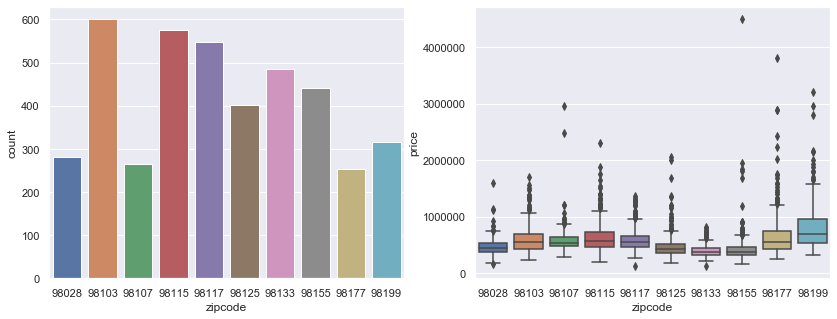

In [29]:
zipcode = kc_hot_zipcodes['zipcode'].value_counts()



fig, ax = plt.subplots(ncols=2, figsize=(14,5))
sns.countplot(x='zipcode', data=kc_hot_zipcodes, ax=ax[0])
sns.boxplot(x='zipcode', y= 'price',
            data=kc_hot_zipcodes, ax=ax[1])
plt.show()

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x576 with 0 Axes>

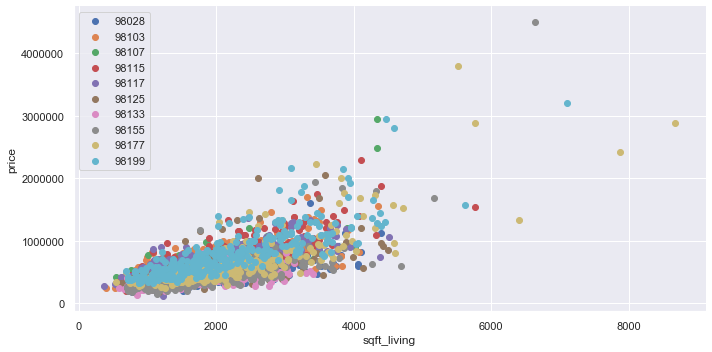

In [30]:
plt.figure(figsize = (12,8))
g = sns.FacetGrid(data=kc_hot_zipcodes, hue='zipcode',size= 5, aspect=2)
g.map(plt.scatter, "sqft_living", "price")
plt.legend()
plt.show()

In [31]:
corr = kc_hot_zipcodes.corr()
corr.style.background_gradient().set_precision(2)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15
price,1,0.34,0.49,0.7,0.18,0.14,0.29,0.51,0.1,0.64,0.63,0.37,-0.33,-0.19,0.52,0.18
bedrooms,0.34,1,0.52,0.64,0.2,0.062,0.016,0.13,0.079,0.33,0.52,0.4,0.11,0.11,0.34,0.17
bathrooms,0.49,0.52,1,0.69,0.062,0.44,0.069,0.23,-0.042,0.6,0.62,0.35,-0.042,-0.0023,0.37,0.065
sqft_living,0.7,0.64,0.69,1,0.33,0.12,0.13,0.39,0.069,0.65,0.82,0.62,0.045,0.046,0.62,0.33
sqft_lot,0.18,0.2,0.062,0.33,1,-0.29,0.12,0.21,0.043,0.14,0.29,0.16,0.45,0.27,0.4,0.77
floors,0.14,0.062,0.44,0.12,-0.29,1,0.032,0.019,-0.22,0.39,0.36,-0.27,-0.22,-0.11,-0.064,-0.3
waterfront,0.29,0.016,0.069,0.13,0.12,0.032,1,0.31,-0.012,0.13,0.14,0.046,0.042,0.061,0.12,0.097
view,0.51,0.13,0.23,0.39,0.21,0.019,0.31,1,0.014,0.38,0.31,0.25,-0.033,-0.081,0.5,0.24
condition,0.1,0.079,-0.042,0.069,0.043,-0.22,-0.012,0.014,1,-0.13,-0.055,0.19,-0.041,-0.068,0.026,0.054
grade,0.64,0.33,0.6,0.65,0.14,0.39,0.13,0.38,-0.13,1,0.66,0.23,-0.096,-0.087,0.51,0.17


In [32]:
# kc_hot_zipcodes['bathrooms'] = kc_hot_zipcodes['bathrooms'].astype(str)
# kc_hot_zipcodes['bedrooms'] = kc_hot_zipcodes['bedrooms'].astype(str)
# kc_hot_zipcodes['condition'] = kc_hot_zipcodes['condition'].astype(str)
# kc_hot_zipcodes['floors'] = kc_hot_zipcodes['floors'].astype(str)
# kc_hot_zipcodes['grade'] = kc_hot_zipcodes['grade'].astype(str)
# kc_hot_zipcodes['sqft_basement'] = kc_hot_zipcodes['sqft_basement'].astype(float)
# kc_hot_zipcodes['view'] = kc_hot_zipcodes['view'].astype(str)
# kc_hot_zipcodes['waterfront'] = kc_hot_zipcodes['waterfront'].astype(str)
# kc_hot_zipcodes['yr_renovated'] = pd.to_datetime(kc_hot_zipcodes['yr_renovated'])

In [33]:
kc_hot_zipcodes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4168 entries, 9587 to 16580
Data columns (total 21 columns):
id               4168 non-null object
date             4168 non-null datetime64[ns]
price            4168 non-null float64
bedrooms         4168 non-null int64
bathrooms        4168 non-null float64
sqft_living      4168 non-null int64
sqft_lot         4168 non-null int64
floors           4168 non-null float64
waterfront       3713 non-null float64
view             4168 non-null float64
condition        4168 non-null int64
grade            4168 non-null int64
sqft_above       4168 non-null int64
sqft_basement    4168 non-null float64
yr_built         4168 non-null datetime64[ns]
yr_renovated     3376 non-null datetime64[ns]
zipcode          4168 non-null object
lat              4168 non-null float64
long             4168 non-null float64
sqft_living15    4168 non-null int64
sqft_lot15       4168 non-null int64
dtypes: datetime64[ns](3), float64(8), int64(8), object(2)
memory u

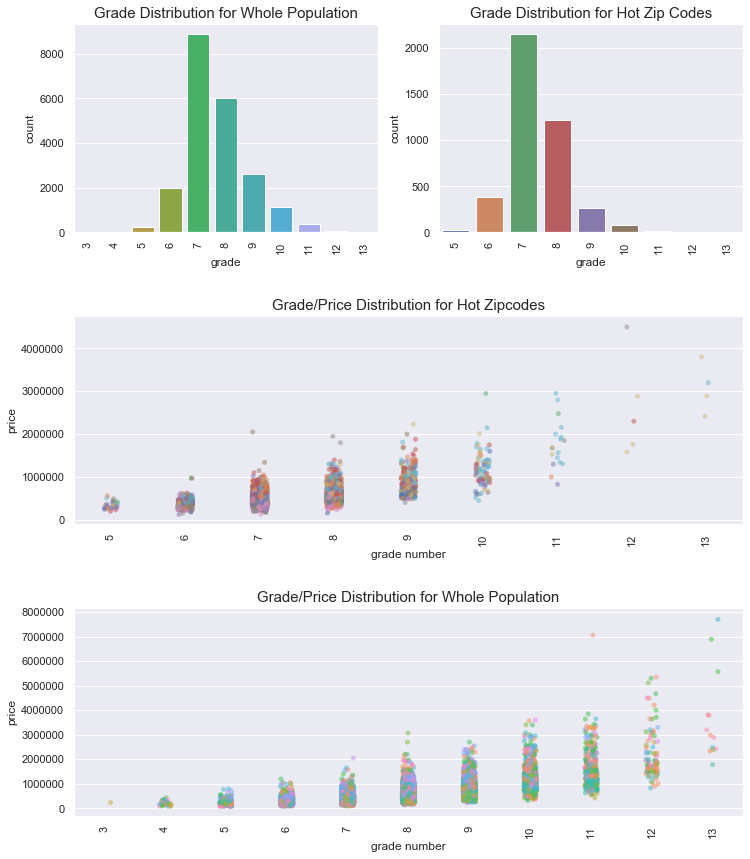

In [34]:
# Whole Population 
kc_grade = kc_hot_zipcodes.sort_values(by=['grade'])
kc_grade_full = kc.sort_values(by =['grade'])

plt.figure(figsize = (12,8))
plt.subplots_adjust(hspace = 0.4, top = 1.5)

ax1 = plt.subplot(321)
ax1 = sns.countplot(x="grade", data=kc_grade_full,
                    ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.set_title("Grade Distribution for Whole Population", fontsize=15)

ax1.set_xlabel("grade")

# Add in Plot 2

ax2 = plt.subplot(322)
ax2 = sns.countplot(x="grade", data=kc_grade,
                    ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.set_title("Grade Distribution for Hot Zip Codes", fontsize=15)
ax2.set_xlabel("grade")

ax3 = plt.subplot(312)
ax3 = sns.stripplot(x="grade", y="price",
                    data=kc_grade, alpha=0.5,
                    jitter=True, hue="zipcode"
                   )
ax3.set_title("Grade/Price Distribution for Hot Zipcodes", fontsize=15)
ax3.set_xlabel("grade number")
ax3.set_ylabel("price")
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=90)
plt.legend().remove()
           
ax4 = plt.subplot(313)
ax4 = sns.stripplot(x="grade", y="price",
                    data=kc_grade_full, alpha=0.5,
                    jitter=True, hue="zipcode"
                   )
ax4.set_title("Grade/Price Distribution for Whole Population", fontsize=15)
ax4.set_xlabel("grade number")
ax4.set_ylabel("price")

ax4.set_xticklabels(ax4.get_xticklabels(),rotation=90)

plt.legend().remove()
plt.show()

In [35]:
kc_hot_zipcodes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4168 entries, 9587 to 16580
Data columns (total 21 columns):
id               4168 non-null object
date             4168 non-null datetime64[ns]
price            4168 non-null float64
bedrooms         4168 non-null int64
bathrooms        4168 non-null float64
sqft_living      4168 non-null int64
sqft_lot         4168 non-null int64
floors           4168 non-null float64
waterfront       3713 non-null float64
view             4168 non-null float64
condition        4168 non-null int64
grade            4168 non-null int64
sqft_above       4168 non-null int64
sqft_basement    4168 non-null float64
yr_built         4168 non-null datetime64[ns]
yr_renovated     3376 non-null datetime64[ns]
zipcode          4168 non-null object
lat              4168 non-null float64
long             4168 non-null float64
sqft_living15    4168 non-null int64
sqft_lot15       4168 non-null int64
dtypes: datetime64[ns](3), float64(8), int64(8), object(2)
memory u

In [36]:
kc_not_hot_zipcodes = kc[~kc.zipcode.isin(hot_zipcodes_list)]

kc_not_hot_zipcodes

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7316,2202500290,2014-05-02,435000.0,4,1.00,1450,8800,1.0,0.0,0.0,...,7,1450,0.0,1954-01-01,1970-01-01,98006,47.5746,-122.135,1260,8942
20586,7853361370,2014-05-02,555000.0,4,2.50,3310,6500,2.0,0.0,0.0,...,8,3310,0.0,2012-01-01,1970-01-01,98065,47.5150,-121.870,2380,5000
1040,7197300105,2014-05-02,550000.0,4,2.50,1940,10500,1.0,NaN,0.0,...,7,1140,800.0,1976-01-01,1970-01-01,98052,47.6830,-122.114,2200,10500
20543,3438501320,2014-05-02,295000.0,2,2.50,1630,1368,2.0,0.0,0.0,...,7,1280,350.0,2009-01-01,1970-01-01,98106,47.5489,-122.363,1590,2306
9578,1024069009,2014-05-02,675000.0,5,2.50,2820,67518,2.0,0.0,0.0,...,8,2820,0.0,1979-01-01,1970-01-01,98029,47.5794,-122.025,2820,48351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20456,5057100110,2015-05-14,479349.0,5,3.00,3223,6371,2.0,0.0,0.0,...,9,3223,0.0,2014-01-01,1970-01-01,98042,47.3584,-122.163,1979,9008
11548,6752600320,2015-05-14,360000.0,4,2.50,2020,7289,2.0,0.0,0.0,...,7,2020,0.0,1994-01-01,1970-01-01,98031,47.4010,-122.171,2090,7259
19381,8149600265,2015-05-14,725000.0,4,1.75,1980,5850,1.0,NaN,1.0,...,8,1380,600.0,1960-01-01,1970-01-01,98116,47.5607,-122.391,1810,5850
12623,4166600610,2015-05-14,335000.0,3,2.00,1410,44866,1.0,0.0,0.0,...,7,1410,0.0,1985-01-01,1970-01-01,98023,47.3273,-122.370,2950,29152


In [37]:
scaler = StandardScaler()

In [38]:
X = kc_hot_zipcodes[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                   'floors', 'condition', 'grade']]
y = kc_hot_zipcodes['price']

scaled_X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)



In [39]:
scaled_X

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade
0,-0.185339,0.777770,1.046751,-0.332899,-0.743751,0.750819,1.758611
1,0.884596,0.777770,1.337691,0.301460,0.812841,-0.678790,1.758611
2,-0.185339,-0.211975,-0.130231,0.112782,-0.743751,-0.678790,-0.443880
3,0.884596,0.117940,-0.381497,-0.081445,0.034545,-0.678790,-0.443880
4,-1.255275,-1.201721,-1.227866,-0.050230,-0.743751,-0.678790,-0.443880
...,...,...,...,...,...,...,...
4163,-0.185339,-0.211975,0.121035,-0.462961,-0.743751,-0.678790,-0.443880
4164,-1.255275,1.107685,-0.579865,-0.958933,0.812841,-0.678790,0.657365
4165,1.954532,1.437600,1.998916,-0.228155,0.812841,-0.678790,1.758611
4166,-1.255275,-0.211975,-0.553416,0.000061,-0.743751,-0.678790,-1.545126


In [40]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=0)

In [41]:
model_kc = LinearRegression()  
model_kc.fit(X_train, y_train) #training the algorithms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [42]:
#To retrieve the intercept:
print(model_kc.intercept_)
#For retrieving the slope:
print(model_kc.coef_)

551331.5670427437
[-37415.2653822  -13156.81496135 166842.90630109 -14893.21715287
 -11408.54916722  29126.80720934  98726.89193327]


In [43]:
y_pred = model_kc.predict(X_test)

In [44]:
coeff_kc = pd.DataFrame(model_kc.coef_, scaled_X.columns, columns=['Coefficient'])  
coeff_kc

,Coefficient
bedrooms,-37415.265382
bathrooms,-13156.814961
sqft_living,166842.906301
sqft_lot,-14893.217153
floors,-11408.549167
condition,29126.807209
grade,98726.891933


In [45]:
model_kc.fit(X,y)

# Evaluating performance
r2 = model_kc.score(X,y)
r2 = r2.round(2)
print('R2 = {}'.format(r2))

# Understanding the LEARNED model
est_a = model_kc.intercept_
est_B = model_kc.coef_
print('constant: {}'.format(round(est_a,4)))
print('coeficients:  {} estimated'.format(est_B.round(4)))
coeff_kc

R2 = 0.59
constant: -590068.0296
coeficients:  [-3.77214667e+04 -1.77343808e+04  2.14833500e+02 -2.80420000e+00
 -1.76609752e+04  4.25511755e+04  1.08531235e+05] estimated


,Coefficient
bedrooms,-37415.265382
bathrooms,-13156.814961
sqft_living,166842.906301
sqft_lot,-14893.217153
floors,-11408.549167
condition,29126.807209
grade,98726.891933


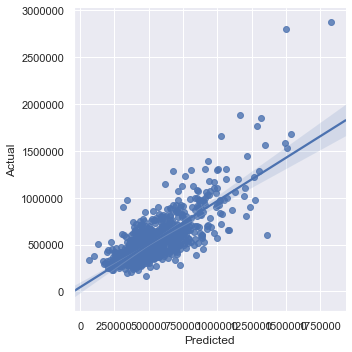

In [46]:
model_kc_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

g = sns.lmplot(x="Predicted", y="Actual", data=model_kc_results)

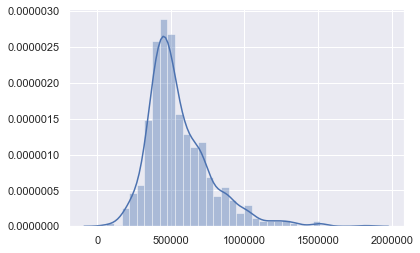

In [62]:
sns.distplot(y_pred)

In [52]:
X_not_hot_zipcodes = kc_not_hot_zipcodes[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                   'floors', 'condition', 'grade']]
y_not_hot_zipcodes = kc_not_hot_zipcodes['price']

scaled_X_not_hot_zipcodes = pd.DataFrame(scaler.fit_transform(X_not_hot_zipcodes), columns=X_not_hot_zipcodes.columns)




In [53]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(scaled_X_not_hot_zipcodes, y_not_hot_zipcodes,
                                                     test_size=0.2, random_state=0)

In [54]:
model_kc_not_hot_zipcodes = LinearRegression()  
model_kc_not_hot_zipcodes.fit(X_train_2, y_train_2) #training the algorithms

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
y_pred_not_hot_zipcodes = model_kc.predict(X_test_2)

In [56]:
coeff_kc_not_hot_zipcodes = pd.DataFrame(model_kc_not_hot_zipcodes.coef_, scaled_X_not_hot_zipcodes.columns,
                                         columns=['Coefficient'])  
coeff_kc_not_hot_zipcodes

,Coefficient
bedrooms,-43532.847781
bathrooms,-6778.053464
sqft_living,220049.791920
sqft_lot,-12578.358094
floors,-18589.043331
condition,41829.049478
grade,132082.653732


In [57]:
model_kc.fit(X_not_hot_zipcodes,y_not_hot_zipcodes)

# Evaluating performance
r2 = model_kc.score(X_not_hot_zipcodes,y_not_hot_zipcodes)
r2 = r2.round(2)
print('R2 = {}'.format(r2))

# Understanding the LEARNED model
est_a = model_kc_not_hot_zipcodes.intercept_
est_B = model_kc_not_hot_zipcodes.coef_
print('constant: {}'.format(round(est_a,4)))
print('coeficients:  {} estimated'.format(est_B.round(4)))
coeff_kc_not_hot_zipcodes

R2 = 0.57
constant: 541334.7179
coeficients:  [-43532.8478  -6778.0535 220049.7919 -12578.3581 -18589.0433  41829.0495
 132082.6537] estimated


,Coefficient
bedrooms,-43532.847781
bathrooms,-6778.053464
sqft_living,220049.791920
sqft_lot,-12578.358094
floors,-18589.043331
condition,41829.049478
grade,132082.653732


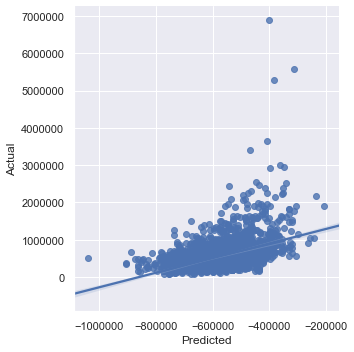

In [60]:
model_kc_not_hot_zipcdoes_results = pd.DataFrame({'Actual': y_test_2, 'Predicted': y_pred_not_hot_zipcodes})

g = sns.lmplot(x="Predicted", y="Actual", data=model_kc_not_hot_zipcdoes_results)

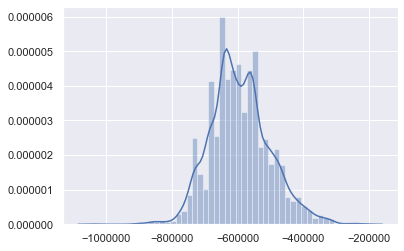

In [63]:
sns.distplot(y_pred_not_hot_zipcodes)

In [61]:
coeff_kc_not_hot_zipcodes % coeff_kc

,Coefficient
bedrooms,-6117.582399
bathrooms,-6778.053464
sqft_living,53206.885618
sqft_lot,-12578.358094
floors,-7180.494163
condition,12702.242269
grade,33355.761798


In [64]:
# gdf=gpd.GeoDataFrame(merged_2, geometry=merged_2.geometry)

# gdf.plot(column='rate_of_price_increase', k=5, colormap='OrRd', legend=True, figsize=(20,12))

kc_not_hot_zipcodes

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7316,2202500290,2014-05-02,435000.0,4,1.00,1450,8800,1.0,0.0,0.0,...,7,1450,0.0,1954-01-01,1970-01-01,98006,47.5746,-122.135,1260,8942
20586,7853361370,2014-05-02,555000.0,4,2.50,3310,6500,2.0,0.0,0.0,...,8,3310,0.0,2012-01-01,1970-01-01,98065,47.5150,-121.870,2380,5000
1040,7197300105,2014-05-02,550000.0,4,2.50,1940,10500,1.0,NaN,0.0,...,7,1140,800.0,1976-01-01,1970-01-01,98052,47.6830,-122.114,2200,10500
20543,3438501320,2014-05-02,295000.0,2,2.50,1630,1368,2.0,0.0,0.0,...,7,1280,350.0,2009-01-01,1970-01-01,98106,47.5489,-122.363,1590,2306
9578,1024069009,2014-05-02,675000.0,5,2.50,2820,67518,2.0,0.0,0.0,...,8,2820,0.0,1979-01-01,1970-01-01,98029,47.5794,-122.025,2820,48351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20456,5057100110,2015-05-14,479349.0,5,3.00,3223,6371,2.0,0.0,0.0,...,9,3223,0.0,2014-01-01,1970-01-01,98042,47.3584,-122.163,1979,9008
11548,6752600320,2015-05-14,360000.0,4,2.50,2020,7289,2.0,0.0,0.0,...,7,2020,0.0,1994-01-01,1970-01-01,98031,47.4010,-122.171,2090,7259
19381,8149600265,2015-05-14,725000.0,4,1.75,1980,5850,1.0,NaN,1.0,...,8,1380,600.0,1960-01-01,1970-01-01,98116,47.5607,-122.391,1810,5850
12623,4166600610,2015-05-14,335000.0,3,2.00,1410,44866,1.0,0.0,0.0,...,7,1410,0.0,1985-01-01,1970-01-01,98023,47.3273,-122.370,2950,29152


In [65]:
merged_2

,COUNTY,SHAPE_Leng,SHAPE_Area,geometry,zipcode,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,rate_of_price_increase
0,033,117508.211718,2.280129e+08,"POLYGON ((-122.21842 47.43750, -122.21935 47.4...",98031,300970.405904,3.498155,2.154982,1932.273063,12138.682657,1.446494,0.000000,0.007380,3.498155,7.380074,1708.804428,205.276753,1911.317343,8488.538745,756.605527
1,033,166737.664791,4.826754e+08,"MULTIPOLYGON (((-122.24187 47.44122, -122.2411...",98032,253317.317073,3.406504,1.713415,1745.577236,10395.894309,1.223577,0.000000,0.081301,3.642276,7.146341,1436.910569,308.666667,1670.317073,9291.959350,1127.812321
2,033,101363.840369,2.566747e+08,"POLYGON ((-122.20571 47.65170, -122.20511 47.6...",98033,804063.883991,3.559165,2.333527,2379.371230,10508.206497,1.495360,0.008000,0.299304,3.487239,8.074246,2058.150812,316.371230,2207.243619,9929.505800,-94.936709
3,033,98550.452509,2.725072e+08,"POLYGON ((-122.17551 47.73706, -122.17554 47.7...",98034,522298.909761,3.462247,2.123389,1977.657459,9770.451197,1.317680,0.010373,0.202578,3.381215,7.506446,1662.025783,309.333333,1913.158379,8491.079190,2096.773109
4,033,94351.264837,2.000954e+08,"POLYGON ((-122.16746 47.38549, -122.16746 47.3...",98030,297939.221344,3.505929,2.169960,1970.118577,11802.505929,1.505929,0.000000,0.023715,3.292490,7.422925,1809.802372,158.221344,1924.743083,8576.122530,690.409695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,033,95211.465988,1.596729e+08,"POLYGON ((-122.35904 47.77776, -122.35904 47.7...",98177,677625.767717,3.397638,2.099409,2325.511811,11921.086614,1.277559,0.004274,0.814961,3.496063,7.976378,1838.944882,473.377953,2186.220472,11704.362205,1470.588235
70,033,66906.676245,1.353505e+08,"POLYGON ((-122.21902 47.50057, -122.21902 47.5...",98178,312850.937984,3.306202,1.738372,1736.744186,8308.457364,1.186047,0.039301,0.542636,3.325581,6.829457,1329.728682,399.612403,1650.503876,8132.344961,679.096335
71,033,124157.387829,2.108446e+08,"POLYGON ((-122.31456 47.42438, -122.31454 47.4...",98198,305287.589091,3.178182,1.792727,1749.530909,10553.425455,1.225455,0.037975,0.603636,3.450909,7.109091,1477.785455,264.436364,1715.927273,9502.130909,715.322553
72,033,56826.422800,1.145346e+08,"MULTIPOLYGON (((-122.40912 47.67160, -122.4089...",98199,792939.325949,3.208861,2.166930,2162.246835,5439.721519,1.466772,0.003636,0.553797,3.503165,8.009494,1591.487342,565.601266,1992.341772,5282.101266,1327.419492
